In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../../..')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.misc.plot import plot_n_components
from magrec.prop.Propagator import FourierPadder
from magrec.misc.load import load_matlab_data

from magrec import __datapath__

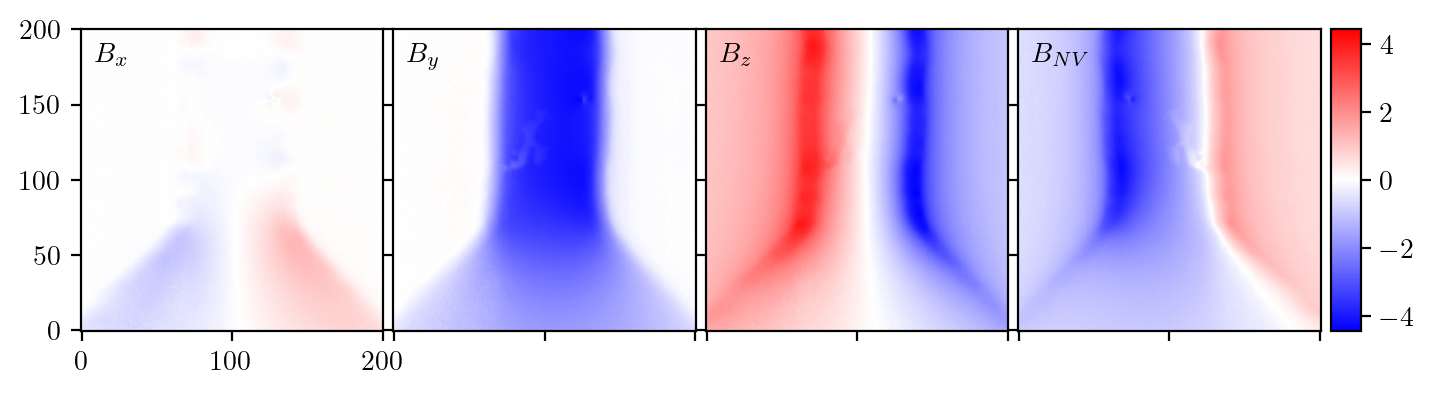

In [95]:
Bx = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bx.txt" )
By = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "By.txt" )
Bz = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bz.txt" )

B = np.empty(shape=(4,201,201))

setTheta = np.deg2rad(54.7)
setPhi = np.deg2rad(45)

unv = [np.sin(setTheta) * np.cos(setPhi),
        np.sin(setTheta) * np.sin(setPhi),
        np.cos(setTheta)]

B[0,::] = Bx
B[1,::] = By
B[2,::] = Bz
B[3,::] = np.flipud(Bx*unv[0] + By*unv[1] + Bz*unv[2])

B_NV = torch.from_numpy(B[3])
B_NV.shape  # (39, 141) — notice that it is probably bad to have an odd number of pixels

B_NV = torch.concatenate((B_NV, torch.fliplr(B_NV)), axis=1)

plot_n_components(B, labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

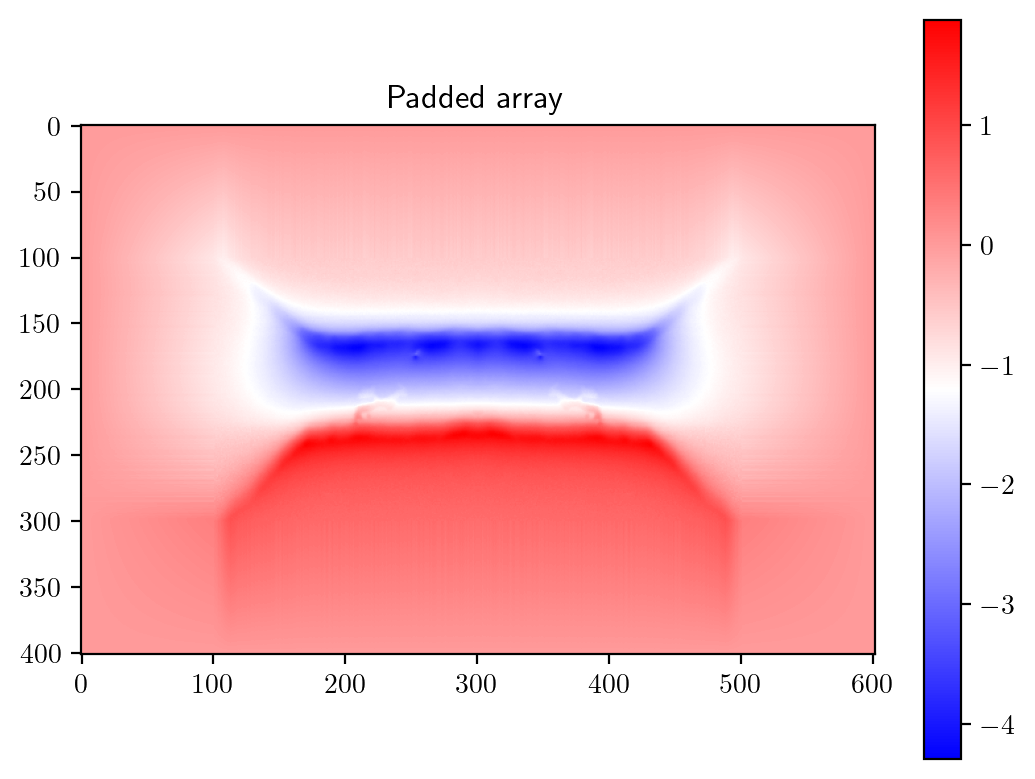

In [22]:
Bpad = FourierPadder.pad_2d(B_NV, (100,100), 'linear_ramp', plot=True)

In [40]:
# data from inspecting the matlab file  
dx=0.408  # in μm
dy=0.408

# data from the .pptx shared by the authors
theta = np.rad2deg(setTheta)  # degrees
phi = np.rad2deg(setPhi)  # degrees

ft = FourierTransform2d(Bpad.shape, dx=dx, dy=dy)
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=theta, phi=phi)

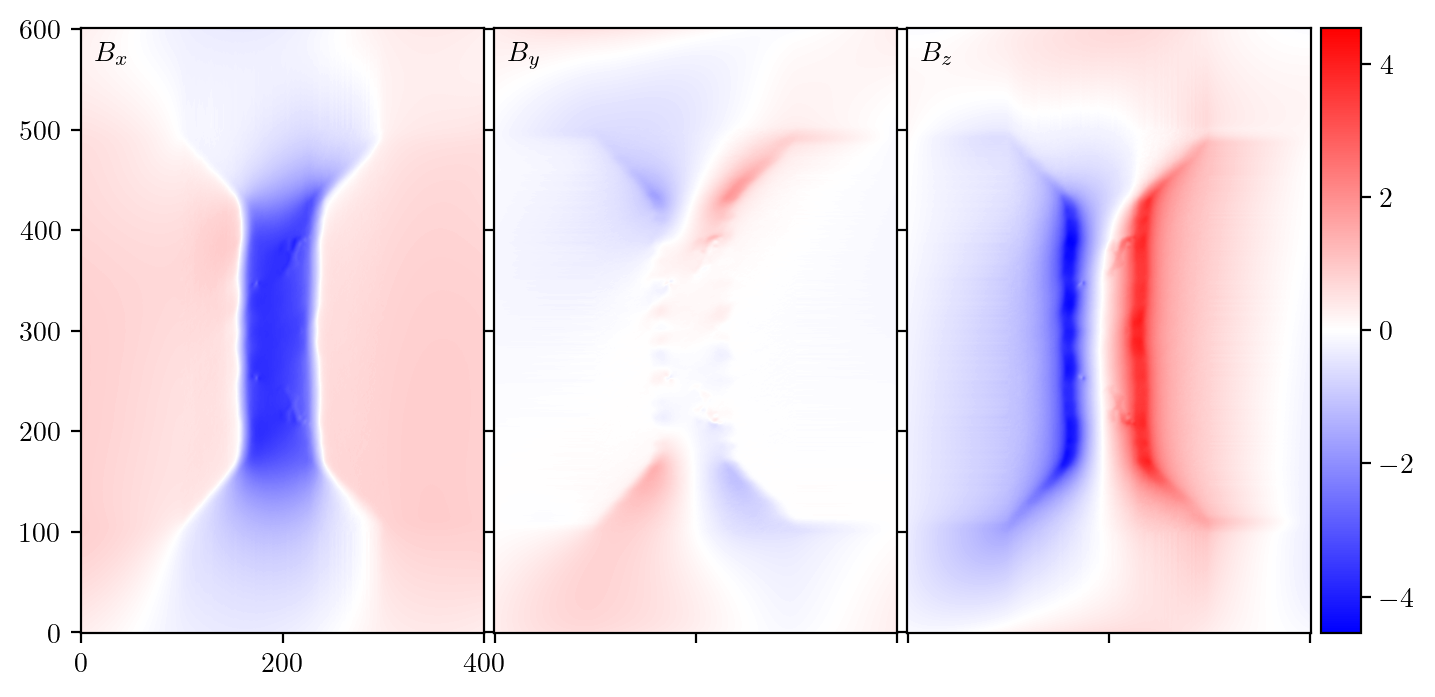

In [41]:
b_NV = ft.forward(Bpad, dim=(-2, -1))
b = torch.einsum("jkl,kl-> jkl", kernel, b_NV)
B = ft.backward(b, dim=(-2, -1))
plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

In [90]:
height = 0.100 # in μm
layer_thickness = 0 # put 1 for now to get result per μm
inversion_kernel = MagneticFieldToCurrentInversion2d.define_kernel_matrix(ft.kx_vector, ft.ky_vector, height=height, layer_thickness=layer_thickness)

In [91]:
bxby = b[:2, :, :].type(dtype=torch.complex64)
jxjy = torch.einsum('vcjk,cjk->vjk', inversion_kernel, bxby)
jxjy[0,::] = FourierPadder.apply_hanning(
    jxjy[0,::], 
    ft.k_matrix, 
    height, 
    high_freq_cutoff = None, 
    low_freq_cutoff = None, 
    )
jxjy[1,::] = FourierPadder.apply_hanning(
    jxjy[1,::], 
    ft.k_matrix ,
    1*height, 
    high_freq_cutoff = height, 
    low_freq_cutoff = None)
JxJy = ft.backward(jxjy, dim=(-2, -1))

Applied a high frequency filter, removing all components smaller than 0.1 um


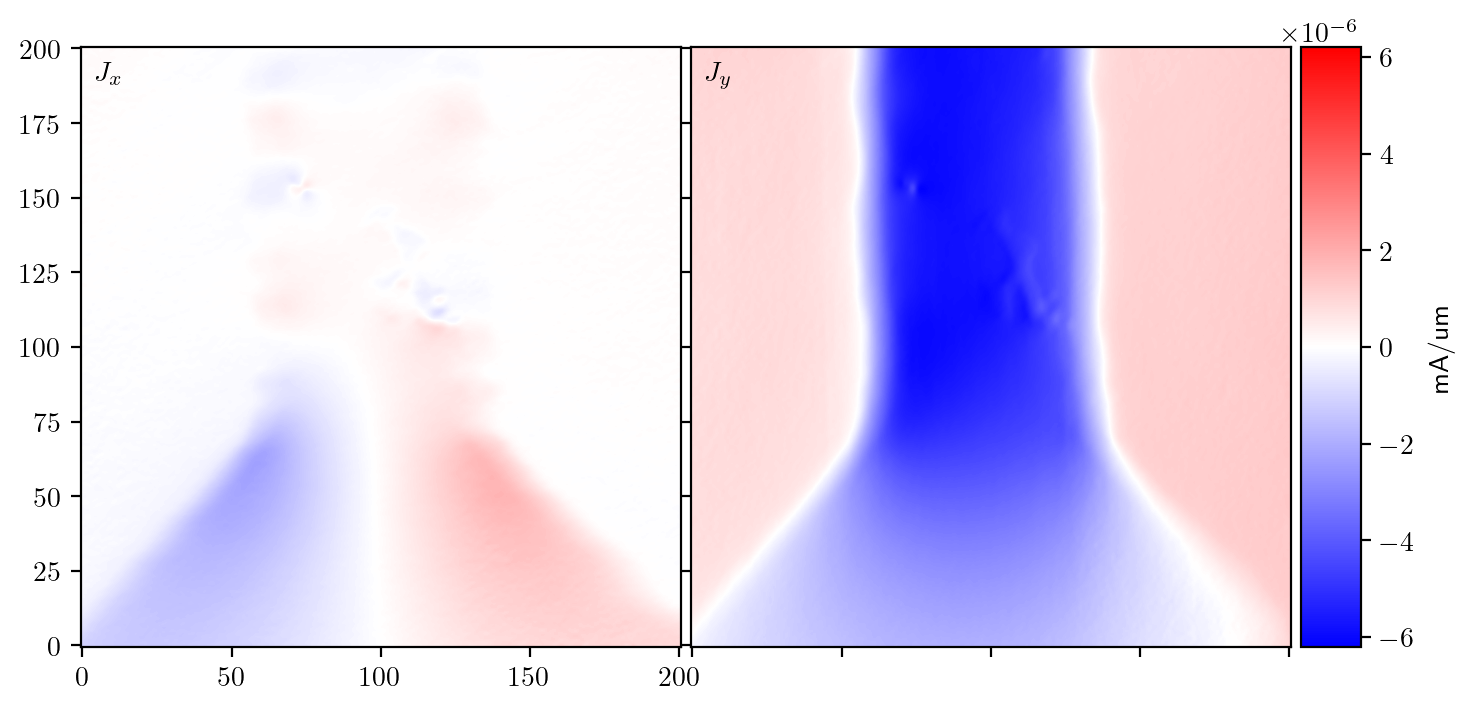

In [92]:
plot_n_components(JxJy[:,100:301,100:301]* 1e-6, symmetric=True, labels=[r"$J_x$", r"$J_y$"], cmap="bwr", units="mA/um",
imshow_kwargs={
    "interpolation": "bicubic",
    })